In [1]:
# ================================================================
# EXPERIMENT 6: EXPERT COUNT ON CIFAR-10
# Testing: 2, 3, 4, 8 experts (all with 128 hidden) on CIFAR-10
# ================================================================


# EXPERIMENT SETUP:
# - Test 2, 3, 4, 8 experts on CIFAR-10 dataset
# - All experts have 128 hidden units (consistent sizing)
# - Same protocol as notebook 4, different dataset
# - Goal: See if MoE helps more on complex dataset

# CIFAR-10 vs MNIST:
# - MNIST: 28×28 grayscale, 10 digit classes (simple)
# - CIFAR-10: 32×32 RGB, 10 object classes (complex)


In [2]:
# ================================================================
# IMPORTS AND SETUP
# ================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
from collections import defaultdict, Counter

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 10)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

print("="*60)
print("EXPERIMENT 6: DATASET COMPLEXITY")
print("="*60)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("="*60)

EXPERIMENT 6: DATASET COMPLEXITY
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


In [3]:
# ================================================================
# DATA LOADING
# ================================================================

def load_cifar10(batch_size=64, data_dir='/kaggle/working/data'):
    """
    Load CIFAR-10 dataset with data augmentation.
    
    CIFAR-10: 50k train + 10k test RGB images (32×32)
    Classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
    """
    print("\n📦 Loading CIFAR-10 Dataset...")
    
    # Training: with data augmentation
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # Testing: no augmentation
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                             num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=2, pin_memory=True)
    
    print(f"✓ Training samples: {len(train_dataset):,}")
    print(f"✓ Test samples: {len(test_dataset):,}")
    print(f"✓ Image size: 32×32 RGB")
    print(f"✓ Input dim: 3072 (32×32×3)")
    
    return train_loader, test_loader

In [4]:
# ================================================================
# BASELINE MODELS + MoE
# ================================================================

class BaselineMLP(nn.Module):
    """
    Baseline MLP for CIFAR-10 comparison.
    
    Architecture matches what would be equivalent to a single strong network.
    Uses same capacity as our MoE configurations for fair comparison.
    """
    def __init__(self, input_dim=3072, hidden_dim=128, output_dim=10):
        super(BaselineMLP, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim * 2)  # 256 hidden
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)  # 128 hidden
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class Expert(nn.Module):
    """Expert network with dropout for CIFAR-10."""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim * 2)  # 256 hidden
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)  # 128 hidden
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Prevent overfitting on CIFAR-10
        self.expert_id = None
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


class GatingNetwork(nn.Module):
    """Gating network."""
    def __init__(self, input_dim, num_experts):
        super(GatingNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, num_experts)
        self.num_experts = num_experts
        
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, x, top_k=1):
        logits = self.fc(x)
        all_gates = F.softmax(logits, dim=1)
        top_gates, top_indices = torch.topk(all_gates, top_k, dim=1)
        top_gates = top_gates / (top_gates.sum(dim=1, keepdim=True) + 1e-10)
        
        return top_indices, top_gates, all_gates


class MoE(nn.Module):
    """MoE for CIFAR-10."""
    def __init__(self, input_dim, num_experts, expert_hidden, output_dim=10, top_k=1):
        super(MoE, self).__init__()
        
        self.num_experts = num_experts
        self.top_k = top_k
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Gating
        self.gating = GatingNetwork(input_dim, num_experts)
        
        # Experts
        self.experts = nn.ModuleList([
            Expert(input_dim, expert_hidden, output_dim)
            for i in range(num_experts)
        ])
        
        for i, expert in enumerate(self.experts):
            expert.expert_id = i
        
        # Tracking
        self.expert_counts = torch.zeros(num_experts)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        if x.dim() > 2:
            x = x.view(batch_size, -1)
        
        # Gating decisions
        top_indices, top_gates, all_gates = self.gating(x, self.top_k)
        
        # Initialize output
        output = torch.zeros(batch_size, self.output_dim).to(x.device)
        
        # Route to experts
        for k in range(self.top_k):
            expert_idx = top_indices[:, k]
            gate_weight = top_gates[:, k]
            
            for expert_id in range(self.num_experts):
                mask = (expert_idx == expert_id)
                
                if mask.any():
                    expert_input = x[mask]
                    expert_output = self.experts[expert_id](expert_input)
                    output[mask] += gate_weight[mask].unsqueeze(1) * expert_output
                    self.expert_counts[expert_id] += mask.sum().item()
        
        # Load balancing loss
        aux_loss = self.compute_load_balancing_loss(all_gates, top_indices)
        
        return output, aux_loss
    
    def compute_load_balancing_loss(self, gates, top_indices):
        """Switch Transformer load balancing loss."""
        importance = gates.mean(dim=0)
        load = torch.zeros(self.num_experts).to(gates.device)
        
        for i in range(self.num_experts):
            mask = (top_indices == i).any(dim=1)
            load[i] = mask.float().mean()
        
        loss = self.num_experts * (importance * load).sum()
        return loss
    
    def count_parameters(self):
        """Count trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def get_expert_utilization(self):
        """Get expert utilization statistics."""
        total = self.expert_counts.sum()
        if total == 0:
            percentages = [0.0] * self.num_experts
            entropy = 0.0
        else:
            percentages = (self.expert_counts / total * 100).tolist()
            probs = self.expert_counts / total
            entropy = -(probs * torch.log(probs + 1e-10)).sum().item()
        
        return {
            'counts': self.expert_counts.tolist(),
            'percentages': percentages,
            'entropy': entropy,
            'max_usage': max(percentages) if percentages else 0,
            'min_usage': min(percentages) if percentages else 0,
            'std_usage': np.std(percentages) if percentages else 0
        }
    
    def reset_expert_counts(self):
        """Reset expert usage tracking."""
        self.expert_counts = torch.zeros(self.num_experts)

In [5]:
# ================================================================
# TRAINING FUNCTIONS
# ================================================================

def train_epoch(model, train_loader, optimizer, criterion, device, epoch, alpha=0.01):
    """Train for one epoch."""
    model.train()
    total_task_loss = 0
    total_aux_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output, aux_loss = model(data)
        
        task_loss = criterion(output, target)
        total_loss_batch = task_loss + alpha * aux_loss
        
        total_loss_batch.backward()
        optimizer.step()
        
        total_task_loss += task_loss.item()
        total_aux_loss += aux_loss.item()
        
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
        
        pbar.set_postfix({
            'loss': f'{task_loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    avg_task_loss = total_task_loss / len(train_loader)
    avg_aux_loss = total_aux_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    return avg_task_loss, avg_aux_loss, train_acc


def evaluate(model, test_loader, criterion, device):
    """Evaluate model."""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc


def train_model(model, train_loader, test_loader, epochs=15, lr=0.001, 
                alpha=0.01, device='cuda'):
    """Complete training loop."""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    model = model.to(device)
    
    history = {
        'train_loss': [],
        'aux_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'expert_utilization': [],
        'epoch_times': []
    }
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        model.reset_expert_counts()
        
        # Train
        task_loss, aux_loss, train_acc = train_epoch(
            model, train_loader, optimizer, criterion, device, epoch, alpha
        )
        
        # Evaluate
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        # Get utilization
        util = model.get_expert_utilization()
        
        epoch_time = time.time() - start_time
        
        # Save history
        history['train_loss'].append(task_loss)
        history['aux_loss'].append(aux_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['expert_utilization'].append(util)
        history['epoch_times'].append(epoch_time)
        
        # Print summary
        print(f"\nEpoch {epoch}/{epochs}:")
        print(f"  Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        print(f"  Expert Usage: {[f'{p:.1f}%' for p in util['percentages']]}")
        print(f"  Entropy: {util['entropy']:.3f} | Std: {util['std_usage']:.2f}")
    
    return history


def train_baseline(model, train_loader, test_loader, epochs=15, lr=0.001, device='cuda'):
    """Training loop for baseline MLP (no load balancing)."""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    model = model.to(device)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'epoch_times': []
    }
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        # Train
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
        
        avg_loss = epoch_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Evaluate
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                correct += (pred == target).sum().item()
                total += target.size(0)
        
        test_loss /= len(test_loader)
        test_acc = 100. * correct / total
        
        epoch_time = time.time() - start_time
        
        # Save history
        history['train_loss'].append(avg_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['epoch_times'].append(epoch_time)
        
        # Print summary
        print(f"\nEpoch {epoch}/{epochs}:")
        print(f"  Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        print(f"  Loss: {avg_loss:.4f}")
    
    return history

In [6]:
# ================================================================
# EXPERIMENT RUNNER
# ================================================================

def run_cifar10_expert_experiment(train_loader, test_loader, device='cuda'):
    """
    Test baseline + different numbers of experts on CIFAR-10
    Baseline: Standard MLP
    MoE: 2, 3, 4, 8 experts (all with 128 hidden)
    """
    print("\n" + "="*60)
    print("EXPERIMENT: BASELINE + EXPERT COUNT ON CIFAR-10")
    print("="*60)
    
    results = {}
    
    # Fixed hyperparameters
    ALPHA = 0.01
    EXPERT_HIDDEN = 128
    EPOCHS = 15
    
    # ============================================================
    # BASELINE MLP
    # ============================================================
    print(f"\n{'='*60}")
    print(f"[0/4] Training Baseline MLP")
    print(f"{'='*60}")
    
    baseline_model = BaselineMLP(input_dim=3072, hidden_dim=128, output_dim=10)
    print(f"Model parameters: {baseline_model.count_parameters():,}")
    
    baseline_history = train_baseline(
        baseline_model, train_loader, test_loader, 
        epochs=EPOCHS, lr=0.001, device=device
    )
    
    results['baseline'] = {
        'history': baseline_history,
        'final_acc': baseline_history['test_acc'][-1],
        'best_acc': max(baseline_history['test_acc']),
        'avg_time': np.mean(baseline_history['epoch_times']),
        'params': baseline_model.count_parameters(),
        'model_type': 'Baseline MLP'
    }
    
    print(f"\nBaseline Summary:")
    print(f"   Final Accuracy: {results['baseline']['final_acc']:.2f}%")
    print(f"   Best Accuracy:  {results['baseline']['best_acc']:.2f}%")
    print(f"   Parameters:     {results['baseline']['params']:,}")
    
    # ============================================================
    # MOE CONFIGURATIONS
    # ============================================================
    expert_counts = [2, 3, 4, 8]
    
    for idx, num_experts in enumerate(expert_counts, 1):
        print(f"\n{'='*60}")
        print(f"[{idx}/4] Testing {num_experts} Experts (128 hidden each)")
        print(f"{'='*60}")
        
        # Create model
        model = MoE(
            input_dim=3072,
            num_experts=num_experts,
            expert_hidden=EXPERT_HIDDEN,
            output_dim=10,
            top_k=1
        )
        
        print(f"Model parameters: {model.count_parameters():,}")
        
        # Train
        history = train_model(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=EPOCHS,
            lr=0.001,
            alpha=ALPHA,
            device=device
        )
        
        # Save results
        final_util = history['expert_utilization'][-1]
        results[num_experts] = {
            'history': history,
            'final_acc': history['test_acc'][-1],
            'best_acc': max(history['test_acc']),
            'final_util': final_util,
            'avg_time': np.mean(history['epoch_times']),
            'params': model.count_parameters(),
            'model_type': f'{num_experts} Experts MoE'
        }
        
        # Print summary
        print(f"\nSummary for {num_experts} Experts:")
        print(f"   Final Accuracy: {results[num_experts]['final_acc']:.2f}%")
        print(f"   Best Accuracy:  {results[num_experts]['best_acc']:.2f}%")
        print(f"   vs Baseline:    {results[num_experts]['final_acc'] - results['baseline']['final_acc']:+.2f}%")
        print(f"   Entropy:        {final_util['entropy']:.3f}")
        print(f"   Usage Std:      {final_util['std_usage']:.2f}")
        print(f"   Parameters:     {results[num_experts]['params']:,}")
        print(f"   Avg Epoch Time: {results[num_experts]['avg_time']:.1f}s")
    
    return results

In [7]:
# ================================================================
# VISUALIZATION
# ================================================================

def plot_cifar10_analysis(results, save_path='/kaggle/working/cifar10_expert_count_analysis.png'):
    """Create comprehensive visualization with baseline comparison."""
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    expert_counts = sorted([k for k in results.keys() if k != 'baseline'])
    colors = ['red', 'blue', 'green', 'purple']
    baseline_acc = results['baseline']['final_acc']
    
    # Row 1: Expert utilization for each MoE configuration
    for idx, num_experts in enumerate(expert_counts):
        ax = fig.add_subplot(gs[0, idx])
        history = results[num_experts]['history']
        epochs = range(1, len(history['test_acc']) + 1)
        
        for expert_id in range(num_experts):
            percentages = [
                util['percentages'][expert_id]
                for util in history['expert_utilization']
            ]
            ax.plot(epochs, percentages, marker='o', label=f'Expert {expert_id}', linewidth=2)
        
        balanced_line = 100 / num_experts
        ax.axhline(y=balanced_line, color='black', linestyle='--', alpha=0.5, label='Balanced')
        
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel('Utilization (%)', fontsize=10)
        ax.set_title(f'{num_experts} Experts', fontsize=12, fontweight='bold')
        ax.legend(fontsize=8, ncol=2 if num_experts > 4 else 1)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 100])
    
    # Row 2: Comparative metrics
    # Accuracy comparison - span 2 columns
    ax = fig.add_subplot(gs[1, 0:2])
    
    # Plot baseline
    baseline_history = results['baseline']['history']
    baseline_epochs = range(1, len(baseline_history['test_acc']) + 1)
    ax.plot(baseline_epochs, baseline_history['test_acc'], 
            marker='s', label='Baseline MLP', color='gray', linewidth=3, linestyle='--')
    
    # Plot MoE configurations
    for idx, num_experts in enumerate(expert_counts):
        history = results[num_experts]['history']
        epochs = range(1, len(history['test_acc']) + 1)
        ax.plot(epochs, history['test_acc'], marker='o', label=f'{num_experts} experts MoE',
                color=colors[idx], linewidth=2)
    
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Test Accuracy (%)', fontsize=11)
    ax.set_title('CIFAR-10: Accuracy Comparison', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Entropy comparison - span 2 columns
    ax = fig.add_subplot(gs[1, 2:4])
    for idx, num_experts in enumerate(expert_counts):
        history = results[num_experts]['history']
        epochs = range(1, len(history['test_acc']) + 1)
        entropies = [util['entropy'] for util in history['expert_utilization']]
        ax.plot(epochs, entropies, marker='o', label=f'{num_experts} experts',
                color=colors[idx], linewidth=2)
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Entropy', fontsize=11)
    ax.set_title('Gating Entropy (MoE only)', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Row 3: Summary metrics
    # Final accuracy comparison (baseline + MoE)
    ax = fig.add_subplot(gs[2, 0])
    
    all_models = ['Baseline'] + [f'{n}E' for n in expert_counts]
    all_accs = [baseline_acc] + [results[n]['final_acc'] for n in expert_counts]
    all_colors = ['gray'] + colors
    
    bars = ax.bar(range(len(all_models)), all_accs, color=all_colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(all_models)))
    ax.set_xticklabels(all_models, rotation=15, ha='right')
    ax.set_ylabel('Final Accuracy (%)', fontsize=11)
    ax.set_title('Final Accuracy: Baseline vs MoE', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Training time comparison
    ax = fig.add_subplot(gs[2, 1])
    num_experts_list = list(expert_counts)
    avg_times = [results[n]['avg_time'] for n in num_experts_list]
    bars = ax.bar(range(len(num_experts_list)), avg_times, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(num_experts_list)))
    ax.set_xticklabels([f'{n}E' for n in num_experts_list])
    ax.set_xlabel('MoE Configuration', fontsize=11)
    ax.set_ylabel('Avg Time (s)', fontsize=11)
    ax.set_title('Training Time Per Epoch', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}s', ha='center', va='bottom', fontsize=10)
    
    # Accuracy gain over baseline
    ax = fig.add_subplot(gs[2, 2])
    gains = [results[n]['final_acc'] - baseline_acc for n in num_experts_list]
    bar_colors = ['green' if g > 0 else 'red' for g in gains]
    bars = ax.bar(range(len(num_experts_list)), gains, color=bar_colors, alpha=0.7, edgecolor='black')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_xticks(range(len(num_experts_list)))
    ax.set_xticklabels([f'{n}E' for n in num_experts_list])
    ax.set_xlabel('MoE Configuration', fontsize=11)
    ax.set_ylabel('Accuracy Gain (%)', fontsize=11)
    ax.set_title('MoE Gain Over Baseline', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for bar, gain in zip(bars, gains):
        height = bar.get_height()
        y_pos = height if height > 0 else height - 0.5
        ax.text(bar.get_x() + bar.get_width()/2., y_pos,
                f'{gain:+.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                fontsize=9, fontweight='bold')
    
    # Final utilization heatmap
    ax = fig.add_subplot(gs[2, 3])
    utilization_matrix = []
    labels = []
    for n in num_experts_list:
        util_percentages = results[n]['final_util']['percentages']
        padded = util_percentages + [0] * (8 - len(util_percentages))
        utilization_matrix.append(padded[:8])
        labels.append(f'{n}')
    
    im = ax.imshow(utilization_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=50)
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels([f'{n} experts' for n in num_experts_list])
    ax.set_xticks(range(8))
    ax.set_xticklabels([f'E{i}' for i in range(8)])
    ax.set_title('Final Expert Utilization', fontsize=12, fontweight='bold')
    
    for i in range(len(labels)):
        for j in range(num_experts_list[i]):
            value = utilization_matrix[i][j]
            if value > 0:
                text = ax.text(j, i, f'{value:.0f}%',
                             ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im, ax=ax, label='Usage (%)')
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nAnalysis plot saved to: {save_path}")
    plt.show()


def print_cifar10_summary(results):
    """Print comprehensive summary table with baseline."""
    print("\n" + "="*90)
    print("CIFAR-10: BASELINE vs MOE EXPERT COUNT EXPERIMENT - SUMMARY")
    print("="*90)
    
    baseline_acc = results['baseline']['final_acc']
    baseline_params = results['baseline']['params']
    
    print(f"\n{'Model':<20} {'Accuracy':<12} {'Best Acc':<12} {'vs Baseline':<12} {'Entropy':<10} {'Params':<12} {'Time/Epoch':<12}")
    print("-" * 90)
    
    # Baseline
    print(f"{'Baseline MLP':<20} {baseline_acc:<12.2f}% {results['baseline']['best_acc']:<12.2f}% "
          f"{'---':<12} {'N/A':<10} {baseline_params:<12,} {results['baseline']['avg_time']:<12.1f}s")
    
    print("-" * 90)
    
    # MoE configurations
    for num_experts in sorted([k for k in results.keys() if k != 'baseline']):
        r = results[num_experts]
        gap = r['final_acc'] - baseline_acc
        gap_str = f"{gap:+.2f}%"
        
        print(f"{f'{num_experts} Experts MoE':<20} {r['final_acc']:<12.2f}% {r['best_acc']:<12.2f}% "
              f"{gap_str:<12} {r['final_util']['entropy']:<10.3f} {r['params']:<12,} {r['avg_time']:<12.1f}s")
    
    print("="*90)
    
    # Analysis
    expert_counts = sorted([k for k in results.keys() if k != 'baseline'])
    
    # Find best MoE
    best_moe = max(expert_counts, key=lambda x: results[x]['final_acc'])
    best_moe_acc = results[best_moe]['final_acc']
    best_moe_gain = best_moe_acc - baseline_acc
    
    print("\nBest Configurations:")
    print(f"   Baseline MLP:      {baseline_acc:.2f}%")
    print(f"   Best MoE:          {best_moe} experts ({best_moe_acc:.2f}%)")
    print(f"   MoE Gain:          {best_moe_gain:+.2f}%")
    
    if best_moe_gain > 1.0:
        print(f"\nSUCCESS: MoE shows clear advantage on CIFAR-10!")
        print(f"   Complex dataset benefits from expert specialization")
    elif best_moe_gain > 0:
        print(f"\nMARGINAL: MoE shows small improvement")
        print(f"   Gain exists but modest on this dataset")
    else:
        print(f"\nBASELINE WINS: MoE underperforms baseline")
        print(f"   May need different architecture or more training")
    
    print("\nKey Findings:")
    
    # Check if accuracy improves with more experts
    moe_accs = [results[n]['final_acc'] for n in expert_counts]
    if moe_accs[-1] > moe_accs[0]:
        print("   • More experts improved accuracy")
    else:
        print("   • More experts did not improve accuracy")
    
    # Check balance
    stds = [results[n]['final_util']['std_usage'] for n in expert_counts]
    if stds[-1] > stds[0]:
        print("   • More experts led to less balanced utilization")
    else:
        print("   • More experts maintained good balance")
    
    # Overall MoE benefit
    avg_moe_gain = np.mean([results[n]['final_acc'] - baseline_acc for n in expert_counts])
    print(f"   • Average MoE gain over baseline: {avg_moe_gain:+.2f}%")
    
    print("\nContext:")
    print("   • CIFAR-10 is challenging for MLPs (flattening loses spatial info)")
    print("   • CNNs typically achieve 70-80% on CIFAR-10")
    print("   • MLPs with proper capacity can reach 50-60%")
    print("   • MoE helps by specializing experts on different visual patterns")
    
    print("\n" + "="*90)

In [8]:
# ================================================================
# MAIN EXECUTION
# ================================================================

    
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64

# Load data
train_loader, test_loader = load_cifar10(batch_size=BATCH_SIZE)

# Run experiment
results = run_cifar10_expert_experiment(train_loader, test_loader, device=DEVICE)


📦 Loading CIFAR-10 Dataset...
✓ Training samples: 50,000
✓ Test samples: 10,000
✓ Image size: 32×32 RGB
✓ Input dim: 3072 (32×32×3)

EXPERIMENT: BASELINE + EXPERT COUNT ON CIFAR-10

[0/4] Training Baseline MLP
Model parameters: 820,874


Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 1/15:
  Train Acc: 24.12% | Test Acc: 29.80%
  Loss: 2.1411


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 2/15:
  Train Acc: 29.22% | Test Acc: 32.92%
  Loss: 1.9292


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 3/15:
  Train Acc: 31.85% | Test Acc: 35.51%
  Loss: 1.8768


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 4/15:
  Train Acc: 33.65% | Test Acc: 36.98%
  Loss: 1.8409


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 5/15:
  Train Acc: 34.18% | Test Acc: 37.75%
  Loss: 1.8117


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 6/15:
  Train Acc: 35.26% | Test Acc: 35.48%
  Loss: 1.7916


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 7/15:
  Train Acc: 35.94% | Test Acc: 37.33%
  Loss: 1.7714


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive(): 
      ^^^ ^  ^ ^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^

   File "/usr/lib/pytho


Epoch 8/15:
  Train Acc: 36.45% | Test Acc: 38.46%
  Loss: 1.7612


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 9/15:
  Train Acc: 36.62% | Test Acc: 37.88%
  Loss: 1.7548


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 10/15:
  Train Acc: 37.19% | Test Acc: 38.49%
  Loss: 1.7429


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 11/15:
  Train Acc: 37.33% | Test Acc: 38.35%
  Loss: 1.7361


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 12/15:
  Train Acc: 37.48% | Test Acc: 37.87%
  Loss: 1.7298


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 13/15:
  Train Acc: 38.23% | Test Acc: 38.18%
  Loss: 1.7157


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 14/15:
  Train Acc: 38.28% | Test Acc: 37.82%
  Loss: 1.7127


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 15/15:
  Train Acc: 38.48% | Test Acc: 38.90%
  Loss: 1.7072

Baseline Summary:
   Final Accuracy: 38.90%
   Best Accuracy:  38.90%
   Parameters:     820,874

[1/4] Testing 2 Experts (128 hidden each)
Model parameters: 1,647,894


Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 1/15:
  Train Acc: 25.94% | Test Acc: 34.69%
  Expert Usage: ['51.1%', '48.9%']
  Entropy: 0.693 | Std: 1.14


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 2/15:
  Train Acc: 30.52% | Test Acc: 35.90%
  Expert Usage: ['51.2%', '48.8%']
  Entropy: 0.693 | Std: 1.20


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
          ^  ^ ^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3


Epoch 3/15:
  Train Acc: 31.77% | Test Acc: 36.55%
  Expert Usage: ['51.0%', '49.0%']
  Entropy: 0.693 | Std: 0.99


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>    
if w.is_alive():Traceback (most recent call last):

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers()
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     ^if w.is_alive():^^
^ ^ ^^^ ^ ^^ ^
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^  ^ ^ ^  ^ ^ ^^ ^ 
^  File "/us


Epoch 4/15:
  Train Acc: 32.50% | Test Acc: 37.28%
  Expert Usage: ['50.6%', '49.4%']
  Entropy: 0.693 | Std: 0.62


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>if w.is_alive():

 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():^
^ ^^^ ^ ^ ^ ^ ^^ ^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^  ^^ ^^^
   File "/usr/lib/py


Epoch 5/15:
  Train Acc: 33.28% | Test Acc: 36.72%
  Expert Usage: ['50.0%', '50.0%']
  Entropy: 0.693 | Std: 0.03


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 6/15:
  Train Acc: 32.33% | Test Acc: 35.06%
  Expert Usage: ['48.7%', '51.3%']
  Entropy: 0.693 | Std: 1.33


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 7/15:
  Train Acc: 33.34% | Test Acc: 34.24%
  Expert Usage: ['48.7%', '51.3%']
  Entropy: 0.693 | Std: 1.33


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 8/15:
  Train Acc: 33.45% | Test Acc: 35.72%
  Expert Usage: ['48.9%', '51.1%']
  Entropy: 0.693 | Std: 1.05


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 9/15:
  Train Acc: 33.85% | Test Acc: 34.90%
  Expert Usage: ['48.6%', '51.4%']
  Entropy: 0.693 | Std: 1.40


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 10/15:
  Train Acc: 33.79% | Test Acc: 33.89%
  Expert Usage: ['48.0%', '52.0%']
  Entropy: 0.692 | Std: 1.96


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 11/15:
  Train Acc: 34.40% | Test Acc: 34.75%
  Expert Usage: ['47.9%', '52.1%']
  Entropy: 0.692 | Std: 2.10


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 12/15:
  Train Acc: 34.44% | Test Acc: 35.99%
  Expert Usage: ['47.4%', '52.6%']
  Entropy: 0.692 | Std: 2.57


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 13/15:
  Train Acc: 35.08% | Test Acc: 35.39%
  Expert Usage: ['47.7%', '52.3%']
  Entropy: 0.692 | Std: 2.29


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 14/15:
  Train Acc: 34.85% | Test Acc: 36.48%
  Expert Usage: ['48.1%', '51.9%']
  Entropy: 0.692 | Std: 1.92


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      if w.is_alive(): 
        ^ ^ ^ ^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._par


Epoch 15/15:
  Train Acc: 35.64% | Test Acc: 36.51%
  Expert Usage: ['48.1%', '51.9%']
  Entropy: 0.692 | Std: 1.88

Summary for 2 Experts:
   Final Accuracy: 36.51%
   Best Accuracy:  37.28%
   vs Baseline:    -2.39%
   Entropy:        0.692
   Usage Std:      1.88
   Parameters:     1,647,894
   Avg Epoch Time: 15.3s

[2/4] Testing 3 Experts (128 hidden each)
Model parameters: 2,471,841


Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0><function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()
    self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      if w.is_alive(): 
       ^ ^ ^ ^ ^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^
   File "/usr/lib/pyth


Epoch 1/15:
  Train Acc: 24.81% | Test Acc: 32.90%
  Expert Usage: ['33.0%', '30.8%', '36.2%']
  Entropy: 1.096 | Std: 2.21


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0><function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():    if w.is_alive():
 
            ^^ ^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.


Epoch 2/15:
  Train Acc: 28.93% | Test Acc: 33.88%
  Expert Usage: ['32.1%', '32.7%', '35.1%']
  Entropy: 1.098 | Std: 1.31


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 3/15:
  Train Acc: 30.87% | Test Acc: 35.01%
  Expert Usage: ['32.9%', '31.1%', '36.0%']
  Entropy: 1.097 | Std: 2.00


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 4/15:
  Train Acc: 30.49% | Test Acc: 35.25%
  Expert Usage: ['32.2%', '31.7%', '36.1%']
  Entropy: 1.097 | Std: 1.97


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 5/15:
  Train Acc: 31.44% | Test Acc: 35.33%
  Expert Usage: ['31.7%', '32.1%', '36.2%']
  Entropy: 1.097 | Std: 2.07


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 6/15:
  Train Acc: 32.17% | Test Acc: 35.54%
  Expert Usage: ['32.0%', '32.3%', '35.7%']
  Entropy: 1.097 | Std: 1.71


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 7/15:
  Train Acc: 31.84% | Test Acc: 35.89%
  Expert Usage: ['31.3%', '32.9%', '35.8%']
  Entropy: 1.097 | Std: 1.85


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 8/15:
  Train Acc: 32.17% | Test Acc: 35.91%
  Expert Usage: ['31.3%', '33.2%', '35.5%']
  Entropy: 1.097 | Std: 1.69


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 9/15:
  Train Acc: 32.34% | Test Acc: 34.18%
  Expert Usage: ['31.4%', '32.8%', '35.8%']
  Entropy: 1.097 | Std: 1.86


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 10/15:
  Train Acc: 32.81% | Test Acc: 34.01%
  Expert Usage: ['31.6%', '32.8%', '35.6%']
  Entropy: 1.097 | Std: 1.68


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 11/15:
  Train Acc: 33.28% | Test Acc: 36.58%
  Expert Usage: ['30.5%', '33.7%', '35.9%']
  Entropy: 1.096 | Std: 2.21


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0> 
Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^  ^^ ^ ^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^^  ^ ^^   
   File "/usr/li


Epoch 12/15:
  Train Acc: 33.55% | Test Acc: 35.75%
  Expert Usage: ['30.9%', '33.1%', '36.0%']
  Entropy: 1.097 | Std: 2.11


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>if w.is_alive():
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers()
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive():^
^ ^^  ^ ^ ^ ^ ^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^ ^
    File "/usr/lib/py


Epoch 13/15:
  Train Acc: 33.82% | Test Acc: 37.28%
  Expert Usage: ['31.1%', '32.9%', '36.0%']
  Entropy: 1.097 | Std: 2.02


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
    
     self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
if w.is_alive():
      ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 14/15:
  Train Acc: 33.97% | Test Acc: 35.14%
  Expert Usage: ['30.7%', '33.4%', '35.9%']
  Entropy: 1.097 | Std: 2.12


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 15/15:
  Train Acc: 34.74% | Test Acc: 36.85%
  Expert Usage: ['31.0%', '32.9%', '36.1%']
  Entropy: 1.097 | Std: 2.09

Summary for 3 Experts:
   Final Accuracy: 36.85%
   Best Accuracy:  37.28%
   vs Baseline:    -2.05%
   Entropy:        1.097
   Usage Std:      2.09
   Parameters:     2,471,841
   Avg Epoch Time: 15.8s

[3/4] Testing 4 Experts (128 hidden each)
Model parameters: 3,295,788


Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 1/15:
  Train Acc: 24.05% | Test Acc: 32.92%
  Expert Usage: ['25.3%', '26.0%', '23.7%', '25.1%']
  Entropy: 1.386 | Std: 0.85


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 2/15:
  Train Acc: 28.33% | Test Acc: 33.83%
  Expert Usage: ['25.2%', '26.3%', '23.2%', '25.2%']
  Entropy: 1.385 | Std: 1.13


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 3/15:
  Train Acc: 29.11% | Test Acc: 34.83%
  Expert Usage: ['26.6%', '25.3%', '23.4%', '24.6%']
  Entropy: 1.385 | Std: 1.16


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 4/15:
  Train Acc: 30.25% | Test Acc: 35.14%
  Expert Usage: ['26.4%', '26.0%', '23.2%', '24.4%']
  Entropy: 1.385 | Std: 1.25


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 5/15:
  Train Acc: 30.54% | Test Acc: 35.32%
  Expert Usage: ['27.6%', '25.9%', '22.9%', '23.6%']
  Entropy: 1.383 | Std: 1.88


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 6/15:
  Train Acc: 31.06% | Test Acc: 35.89%
  Expert Usage: ['27.4%', '25.8%', '23.3%', '23.5%']
  Entropy: 1.384 | Std: 1.71


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 7/15:
  Train Acc: 31.68% | Test Acc: 35.73%
  Expert Usage: ['27.5%', '25.6%', '22.7%', '24.2%']
  Entropy: 1.384 | Std: 1.78


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 8/15:
  Train Acc: 31.90% | Test Acc: 36.16%
  Expert Usage: ['27.6%', '26.1%', '22.2%', '24.1%']
  Entropy: 1.383 | Std: 2.04


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    self._shutdown_workers()    if w.is_alive():

     File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive():
 ^^^ ^^ ^ ^ ^ ^ ^ ^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^ ^
   File "/usr/lib/


Epoch 9/15:
  Train Acc: 32.03% | Test Acc: 34.82%
  Expert Usage: ['26.6%', '26.1%', '22.7%', '24.6%']
  Entropy: 1.384 | Std: 1.50


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    
Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive(): 
      ^^  ^ ^ ^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^ ^ 
    File "/usr/lib/p


Epoch 10/15:
  Train Acc: 32.45% | Test Acc: 36.37%
  Expert Usage: ['26.3%', '25.4%', '22.7%', '25.6%']
  Entropy: 1.385 | Std: 1.37


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 11/15:
  Train Acc: 32.34% | Test Acc: 35.84%
  Expert Usage: ['25.8%', '25.2%', '23.6%', '25.4%']
  Entropy: 1.386 | Std: 0.83


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 12/15:
  Train Acc: 32.63% | Test Acc: 34.66%
  Expert Usage: ['25.7%', '25.2%', '23.0%', '26.1%']
  Entropy: 1.385 | Std: 1.21


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 13/15:
  Train Acc: 32.27% | Test Acc: 36.47%
  Expert Usage: ['25.9%', '25.9%', '22.1%', '26.2%']
  Entropy: 1.384 | Std: 1.70


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 14/15:
  Train Acc: 32.60% | Test Acc: 35.63%
  Expert Usage: ['26.3%', '25.5%', '22.0%', '26.1%']
  Entropy: 1.384 | Std: 1.74


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 15/15:
  Train Acc: 32.87% | Test Acc: 35.66%
  Expert Usage: ['26.0%', '25.5%', '22.3%', '26.2%']
  Entropy: 1.384 | Std: 1.57

Summary for 4 Experts:
   Final Accuracy: 35.66%
   Best Accuracy:  36.47%
   vs Baseline:    -3.24%
   Entropy:        1.384
   Usage Std:      1.57
   Parameters:     3,295,788
   Avg Epoch Time: 16.6s

[4/4] Testing 8 Experts (128 hidden each)
Model parameters: 6,591,576


Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 1/15:
  Train Acc: 21.95% | Test Acc: 30.97%
  Expert Usage: ['11.3%', '13.6%', '11.7%', '13.4%', '12.3%', '13.2%', '12.3%', '12.2%']
  Entropy: 2.078 | Std: 0.76


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 2/15:
  Train Acc: 25.76% | Test Acc: 32.95%
  Expert Usage: ['12.3%', '12.2%', '11.3%', '12.6%', '12.3%', '13.8%', '12.4%', '13.2%']
  Entropy: 2.078 | Std: 0.70


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 3/15:
  Train Acc: 27.06% | Test Acc: 32.10%
  Expert Usage: ['12.3%', '14.2%', '11.5%', '13.1%', '12.7%', '11.7%', '12.1%', '12.4%']
  Entropy: 2.077 | Std: 0.81


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 4/15:
  Train Acc: 28.25% | Test Acc: 33.02%
  Expert Usage: ['12.2%', '13.8%', '11.0%', '12.5%', '12.5%', '12.1%', '12.5%', '13.3%']
  Entropy: 2.077 | Std: 0.79


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers()^^
^^      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^if w.is_alive():^
^ ^  ^^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^ ^  ^ ^ ^  ^^ ^ ^ 
 ^  File "/us


Epoch 5/15:
  Train Acc: 28.55% | Test Acc: 32.69%
  Expert Usage: ['12.2%', '12.9%', '11.0%', '13.5%', '12.3%', '12.3%', '12.0%', '13.9%']
  Entropy: 2.077 | Std: 0.84


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0> 
Traceback (most recent call last):
     File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
     self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
 ^^^    ^if w.is_alive():^
^  ^ ^^ ^^ ^ 
 ^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^ ^ ^ ^^  ^ ^ 
   File "/usr/li


Epoch 6/15:
  Train Acc: 28.78% | Test Acc: 33.26%
  Expert Usage: ['11.7%', '11.7%', '11.4%', '13.0%', '12.3%', '12.0%', '13.5%', '14.4%']
  Entropy: 2.077 | Std: 0.97


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x798b79b123e0> 
  Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  ^    ^^self._shutdown_workers()
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
^^ ^ ^  
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^^ ^  ^^^  ^ ^ 
   File "/usr/


Epoch 7/15:
  Train Acc: 29.00% | Test Acc: 32.61%
  Expert Usage: ['12.1%', '11.1%', '13.7%', '13.1%', '11.5%', '12.4%', '14.0%', '12.1%']
  Entropy: 2.077 | Std: 0.95


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 8/15:
  Train Acc: 29.10% | Test Acc: 31.50%
  Expert Usage: ['12.7%', '11.7%', '12.3%', '13.2%', '11.9%', '12.7%', '13.7%', '11.7%']
  Entropy: 2.078 | Std: 0.67


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 9/15:
  Train Acc: 29.81% | Test Acc: 31.85%
  Expert Usage: ['10.9%', '11.5%', '11.7%', '13.8%', '12.3%', '13.7%', '14.1%', '11.9%']
  Entropy: 2.075 | Std: 1.13


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 10/15:
  Train Acc: 29.53% | Test Acc: 32.91%
  Expert Usage: ['11.6%', '12.1%', '11.2%', '13.7%', '12.5%', '13.5%', '13.7%', '11.6%']
  Entropy: 2.077 | Std: 0.96


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 11/15:
  Train Acc: 29.45% | Test Acc: 31.91%
  Expert Usage: ['11.2%', '12.6%', '11.2%', '14.2%', '12.8%', '14.2%', '12.3%', '11.6%']
  Entropy: 2.075 | Std: 1.12


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 12/15:
  Train Acc: 30.08% | Test Acc: 33.25%
  Expert Usage: ['12.0%', '13.4%', '11.1%', '13.3%', '12.9%', '13.4%', '12.5%', '11.4%']
  Entropy: 2.077 | Std: 0.84


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 13/15:
  Train Acc: 30.57% | Test Acc: 33.87%
  Expert Usage: ['11.6%', '14.1%', '10.9%', '13.3%', '13.0%', '13.1%', '12.3%', '11.8%']
  Entropy: 2.076 | Std: 0.99


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 14/15:
  Train Acc: 30.62% | Test Acc: 33.71%
  Expert Usage: ['11.7%', '15.0%', '11.4%', '13.0%', '12.4%', '12.7%', '12.2%', '11.6%']
  Entropy: 2.076 | Std: 1.09


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 15/15:
  Train Acc: 31.01% | Test Acc: 33.68%
  Expert Usage: ['12.1%', '14.6%', '11.3%', '12.9%', '12.6%', '13.3%', '11.4%', '11.8%']
  Entropy: 2.076 | Std: 1.03

Summary for 8 Experts:
   Final Accuracy: 33.68%
   Best Accuracy:  33.87%
   vs Baseline:    -5.22%
   Entropy:        2.076
   Usage Std:      1.03
   Parameters:     6,591,576
   Avg Epoch Time: 21.8s



Analysis plot saved to: /kaggle/working/cifar10_expert_count_analysis.png


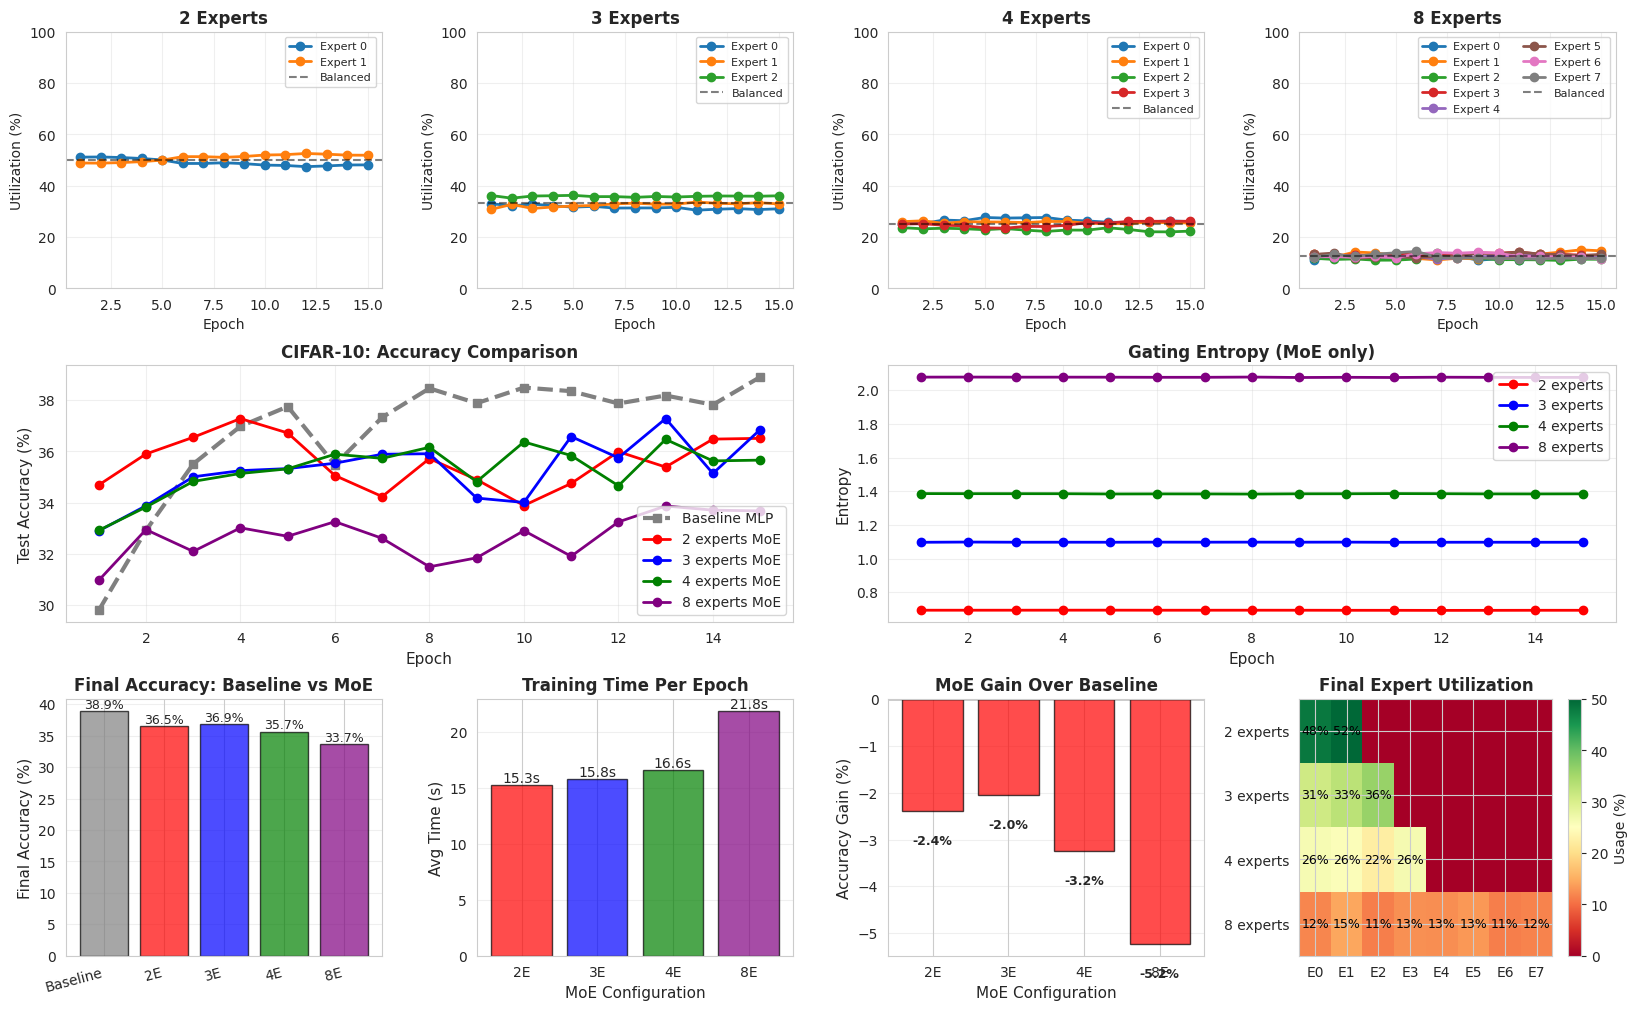


CIFAR-10: BASELINE vs MOE EXPERT COUNT EXPERIMENT - SUMMARY

Model                Accuracy     Best Acc     vs Baseline  Entropy    Params       Time/Epoch  
------------------------------------------------------------------------------------------
Baseline MLP         38.90       % 38.90       % ---          N/A        820,874      13.4        s
------------------------------------------------------------------------------------------
2 Experts MoE        36.51       % 37.28       % -2.39%       0.692      1,647,894    15.3        s
3 Experts MoE        36.85       % 37.28       % -2.05%       1.097      2,471,841    15.8        s
4 Experts MoE        35.66       % 36.47       % -3.24%       1.384      3,295,788    16.6        s
8 Experts MoE        33.68       % 33.87       % -5.22%       2.076      6,591,576    21.8        s

Best Configurations:
   Baseline MLP:      38.90%
   Best MoE:          3 experts (36.85%)
   MoE Gain:          -2.05%

BASELINE WINS: MoE underperforms base

In [9]:
# Visualize
plot_cifar10_analysis(results)

# Summary
print_cifar10_summary(results)

# Save results
torch.save(results, '/kaggle/working/cifar10_expert_count_results.pth')
print(f"\nResults saved to: /kaggle/working/cifar10_expert_count_results.pth")
